In [1]:
!pip install kagglehub

import os
import kagglehub

# Download dataset from Kaggle
path = kagglehub.dataset_download("sachinkumar413/diabetic-retinopathy-dataset")
print("Dataset path:", path)
print("Files in dataset:", os.listdir(path))


Dataset path: /kaggle/input/diabetic-retinopathy-dataset
Files in dataset: ['Severe DR', 'Healthy', 'Moderate DR', 'Mild DR', 'Proliferate DR']


In [8]:
import os
import pandas as pd

path = "/kaggle/input/diabetic-retinopathy-dataset"
data = []

classes = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

for label in classes:
    folder_path = os.path.join(path, label)
    for img_file in os.listdir(folder_path):
        data.append([os.path.join(folder_path, img_file), label])

metadata = pd.DataFrame(data, columns=["image_path", "label"])

print(metadata['label'].value_counts())


label
Healthy           1000
Moderate DR        900
Mild DR            370
Proliferate DR     290
Severe DR          190
Name: count, dtype: int64


Classes found: ['Healthy', 'Mild DR', 'Moderate DR', 'Proliferate DR', 'Severe DR']


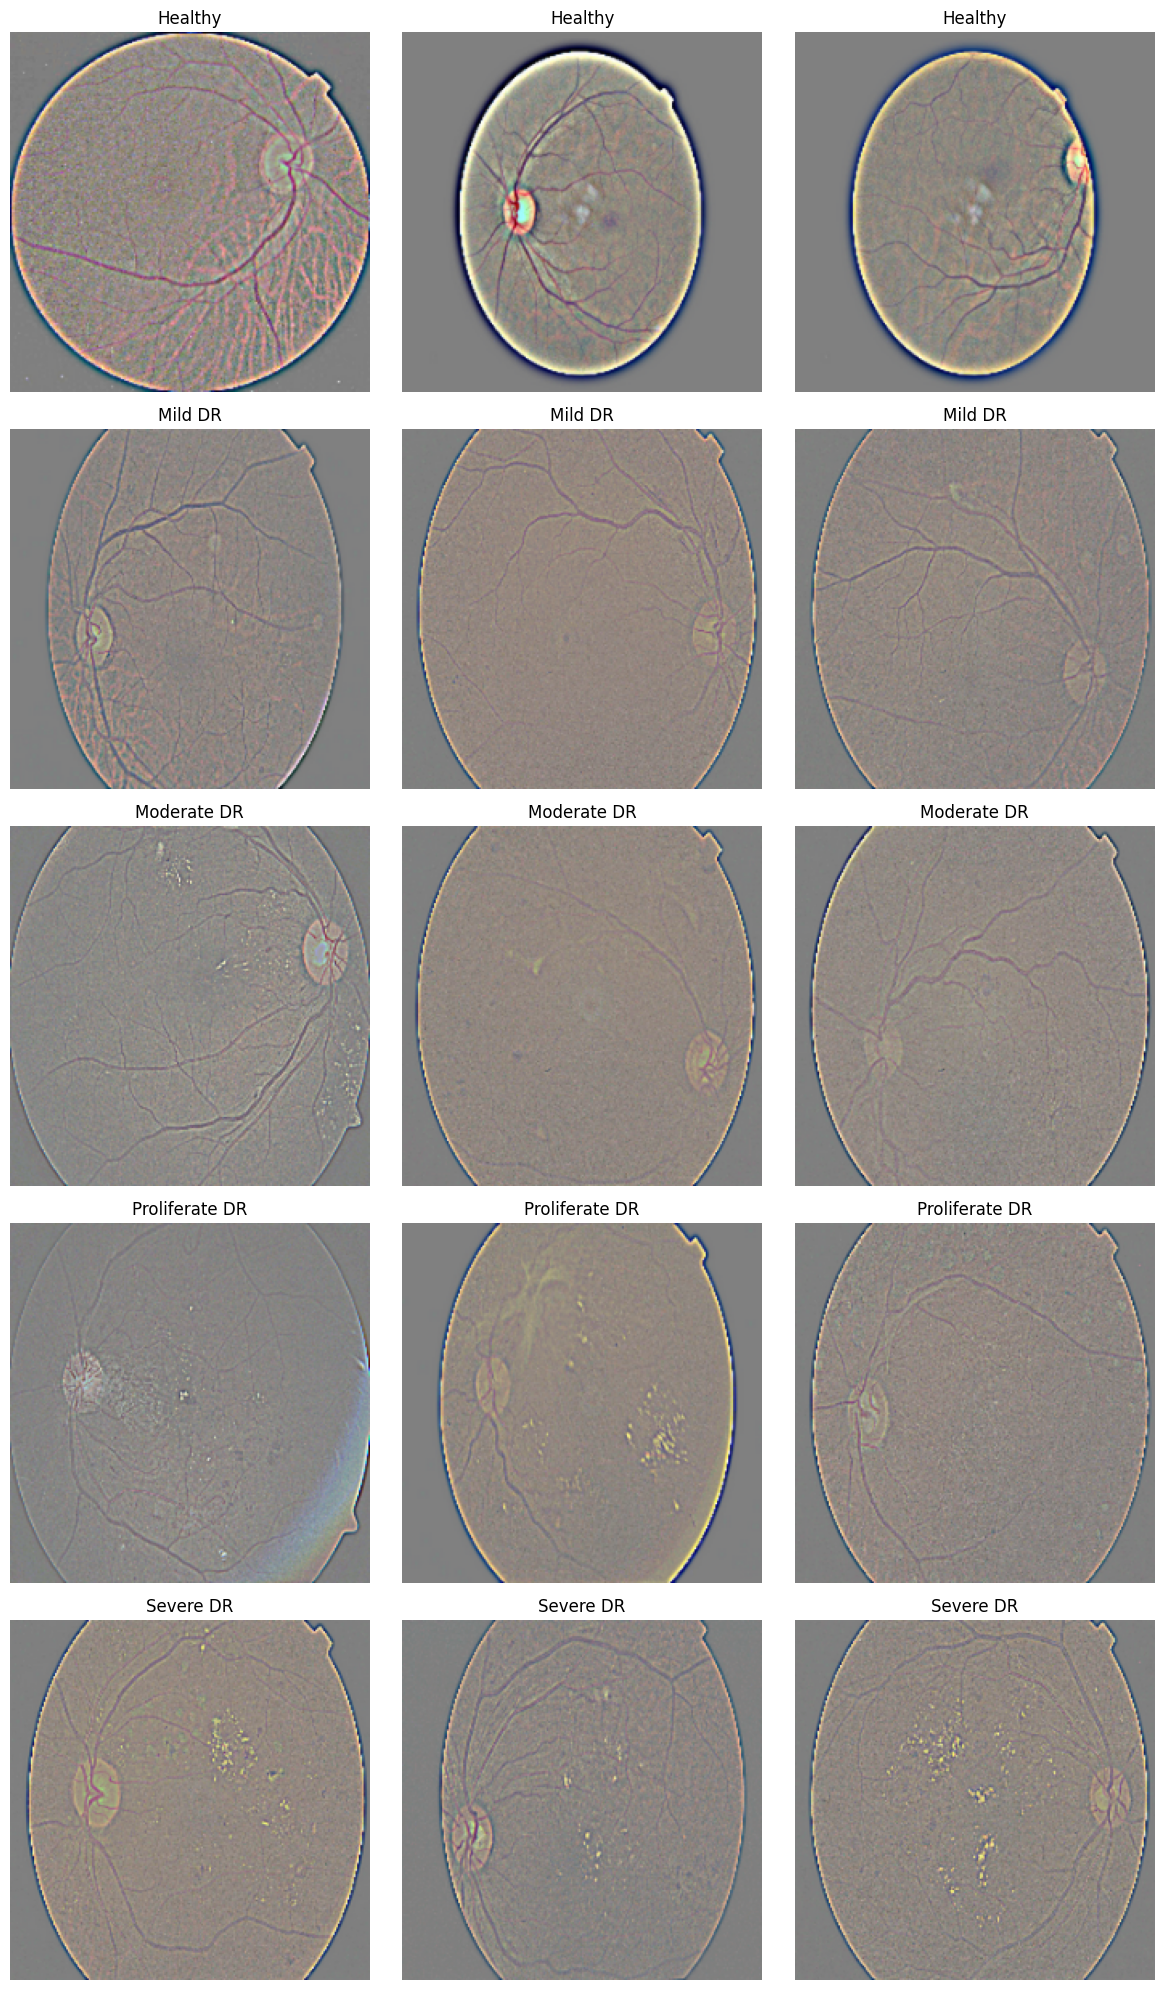

In [10]:
import os
import cv2
import matplotlib.pyplot as plt

dataset_path = "/kaggle/input/diabetic-retinopathy-dataset"

classes = sorted(os.listdir(dataset_path))
print("Classes found:", classes)

plt.figure(figsize=(12, 4 * len(classes)))

for idx, class_name in enumerate(classes):
    class_folder = os.path.join(dataset_path, class_name)
    sample_images = os.listdir(class_folder)[:3]

    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(class_folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))

        plt.subplot(len(classes), 3, idx * 3 + i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis("off")

plt.tight_layout()
plt.show()


In [11]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

encoder = LabelEncoder()
metadata["label_encoded"] = encoder.fit_transform(metadata["label"])

train_df, temp_df = train_test_split(metadata, test_size=0.3, random_state=42, stratify=metadata["label_encoded"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label_encoded"])

print(f"Train set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")


Train set: 1925 images
Validation set: 412 images
Test set: 413 images


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)


Found 1925 validated image filenames belonging to 5 classes.
Found 412 validated image filenames belonging to 5 classes.
Found 413 validated image filenames belonging to 5 classes.


In [13]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,757 (80.64 MB)

 Trainable params: 6,424,069 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=3)
model_checkpoint = ModelCheckpoint('best_vgg16_dr_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.5129 - loss: 1.3347 

61/61 ━━━━━━━━━━━━━━━━━━━━ 1255s 21s/step - accuracy: 0.5138 - loss: 1.3322 - val_accuracy: 0.6068 - val_loss: 1.0545
Epoch 2/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.6032 - loss: 1.0453 

61/61 ━━━━━━━━━━━━━━━━━━━━ 1309s 21s/step - accuracy: 0.6031 - loss: 1.0452 - val_accuracy: 0.5995 - val_loss: 1.0048
Epoch 3/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.6208 - loss: 1.0137 

61/61 ━━━━━━━━━━━━━━━━━━━━ 1244s 20s/step - accuracy: 0.6208 - loss: 1.0136 - val_accuracy: 0.6092 - val_loss: 1.0020
Epoch 4/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.6268 - loss: 0.9730 

61/61 ━━━━━━━━━━━━━━━━━━━━ 1231s 20s/step - accuracy: 0.6266 - loss: 0.9734 - val_accuracy: 0.6044 - val_loss: 0.9907
Epoch 5/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.6143 - loss: 1.0025 

61/61 ━━━━━━━━━━━━━━━━━━━━ 1279s 20s/step - accuracy: 0.6146 - loss: 1.0021 - val_accuracy: 0.6141 - val_loss: 0.9774
Epoch 6/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1289s 20s/step - accuracy: 0.6317 - loss: 0.9838 - val_accuracy: 0.6165 - val_loss: 0.9782
Epoch 7/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.6482 - loss: 0.9411 

61/61 ━━━━━━━━━━━━━━━━━━━━ 1278s 21s/step - accuracy: 0.6482 - loss: 0.9411 - val_accuracy: 0.6359 - val_loss: 0.9596
Epoch 8/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 1278s 21s/step - accuracy: 0.6384 - loss: 0.9570 - val_accuracy: 0.6505 - val_loss: 0.9597
Epoch 9/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.6490 - loss: 0.9021 

61/61 ━━━━━━━━━━━━━━━━━━━━ 1236s 20s/step - accuracy: 0.6491 - loss: 0.9024 - val_accuracy: 0.6626 - val_loss: 0.9387
Epoch 10/10
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.6521 - loss: 0.9037 

61/61 ━━━━━━━━━━━━━━━━━━━━ 1236s 20s/step - accuracy: 0.6522 - loss: 0.9039 - val_accuracy: 0.6578 - val_loss: 0.9168


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 220s 17s/step - accuracy: 0.6717 - loss: 0.8827
Test Accuracy: 0.6852
Test Loss: 0.8510
13/13 ━━━━━━━━━━━━━━━━━━━━ 214s 16s/step


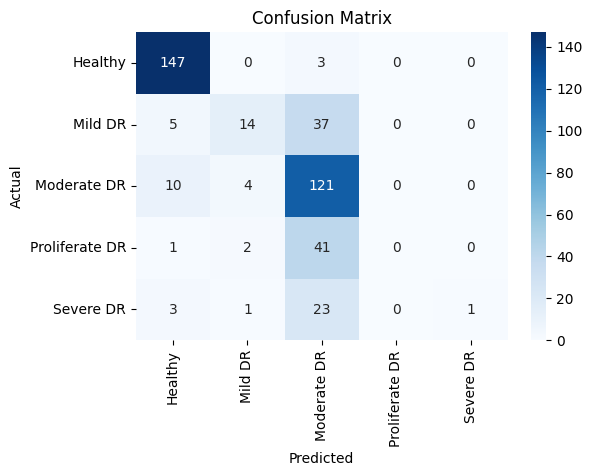

Classification Report:

                precision    recall  f1-score   support

       Healthy       0.89      0.98      0.93       150
       Mild DR       0.67      0.25      0.36        56
   Moderate DR       0.54      0.90      0.67       135
Proliferate DR       0.00      0.00      0.00        44
     Severe DR       1.00      0.04      0.07        28

      accuracy                           0.69       413
     macro avg       0.62      0.43      0.41       413
  weighted avg       0.66      0.69      0.61       413



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))


In [16]:
model.save("best_vgg16.h5")

print("Model saved as 'diabetic_retinopathy_vgg16.h5'")

Model saved as 'diabetic_retinopathy_vgg16.h5'
